In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import PIL
import tensorflow as tf
import torch
import torchvision.models as models
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_directory = '/content/drive/MyDrive/makanan'

In [ ]:
print(os.listdir(data_directory))

['telur_dadar', 'telur_balado', 'ayam_pop', 'dendeng_batokok', 'ayam_goreng', 'gulai_ikan', 'gulai_tunjang', 'gulai_tambusu', 'daging_rendang']


In [ ]:
number_label = {}
total_files = 0
for i in os.listdir(data_directory):
    counting = len(os.listdir(os.path.join(data_directory, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files : " + str(total_files))

Total Files : 1003


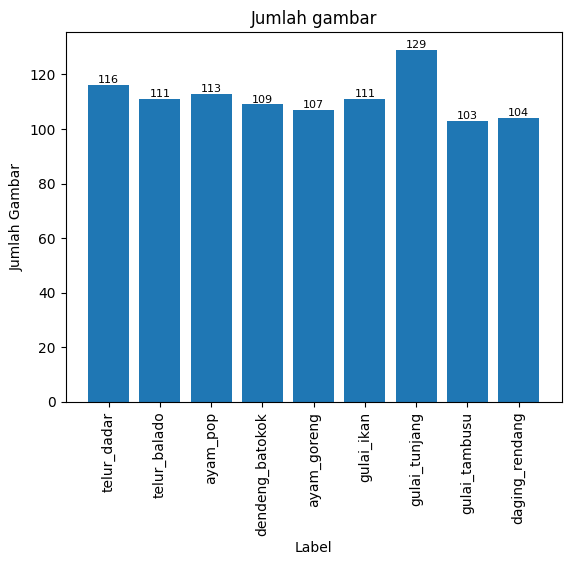

In [ ]:
labels = list(number_label.keys())
counts = list(number_label.values())

plt.bar(labels, counts)
plt.title("Jumlah gambar")
plt.xlabel('Label', fontsize=10)
plt.ylabel('Jumlah Gambar', fontsize=10)

for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=8)
plt.xticks(rotation='vertical')
plt.show()

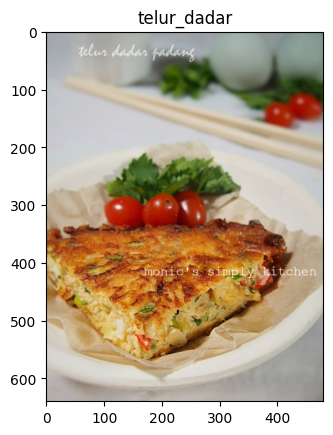

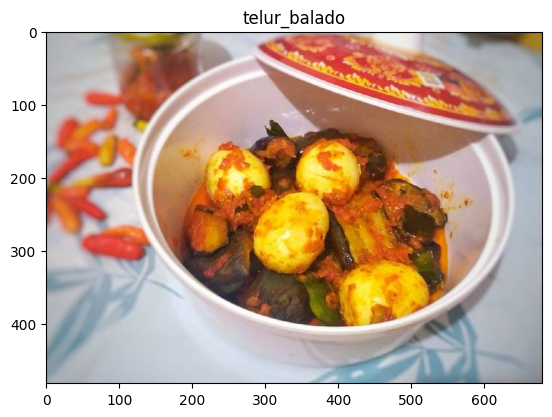

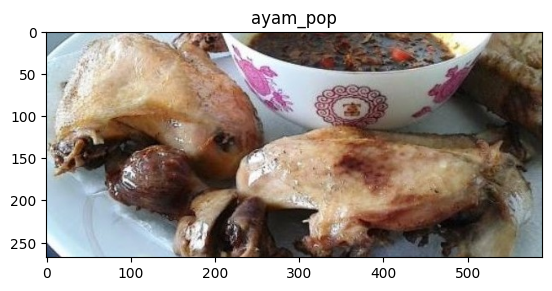

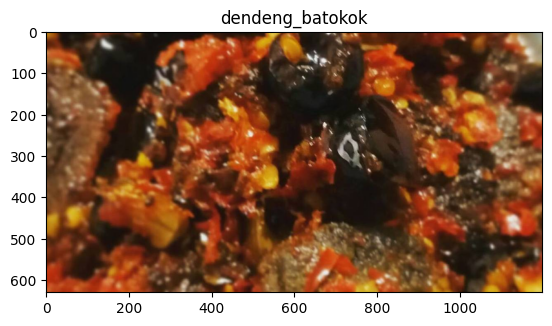

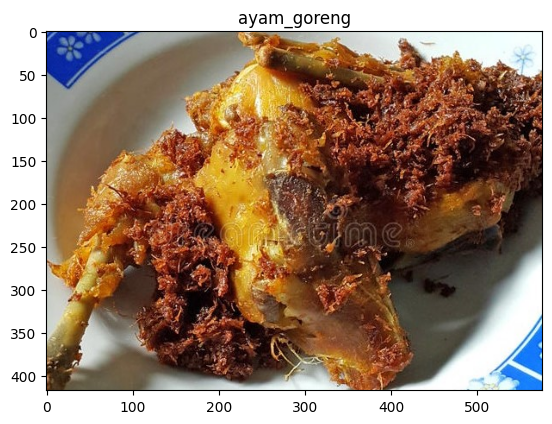

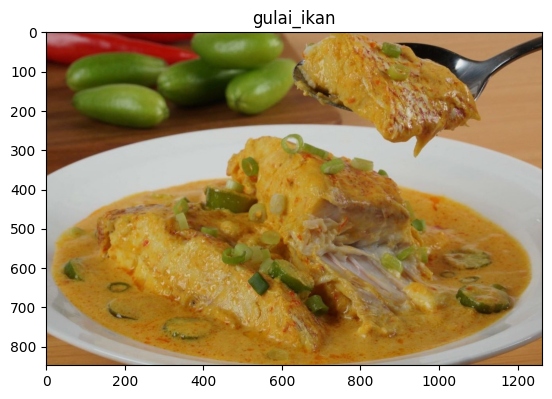

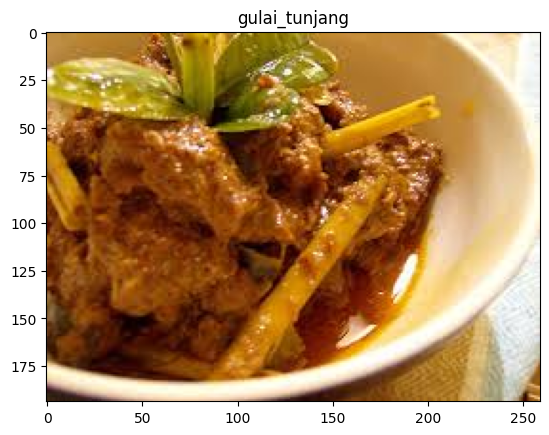

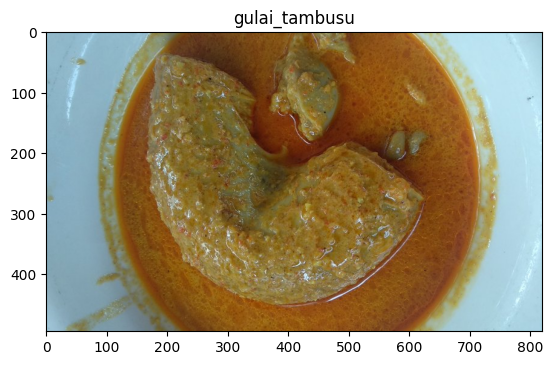

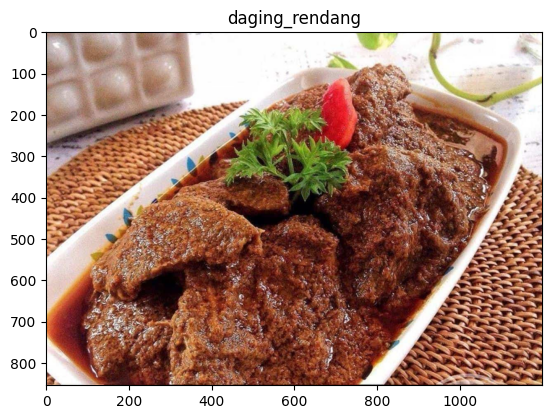

In [ ]:
import matplotlib.image as mpimg

img_each_class = 1
img_samples = {}
classes = list(number_label.keys())


for c in classes:
    temp = os.listdir(os.path.join(data_directory, c))[:img_each_class]
    for item in temp:
        img_path = os.path.join(data_directory, c, item)
        img_samples[c] = img_path

for i in img_samples:
    fig = plt.gcf()
    img = mpimg.imread(img_samples[i])
    plt.title(i)
    plt.imshow(img)
    plt.show()

In [ ]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
SEED = 10000

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2
)

In [ ]:
train_data = datagen.flow_from_directory(
    data_directory,
    class_mode='categorical',
    subset='training',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

Found 807 images belonging to 9 classes.


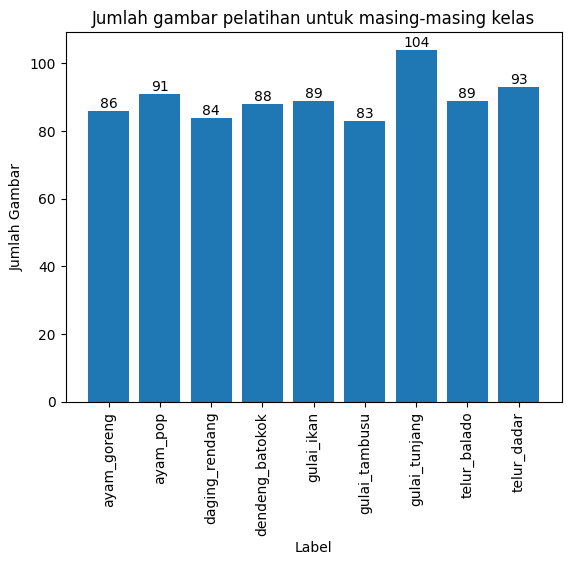

In [ ]:
label_counts = train_data.classes
unique_labels, counts = np.unique(label_counts, return_counts=True)
label_names = list(train_data.class_indices.keys())

plt.bar(label_names, counts)
plt.title("Jumlah gambar pelatihan untuk masing-masing kelas")
plt.xlabel('Label')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation='vertical')

for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

In [ ]:
valid_data = datagen.flow_from_directory(
    data_directory,
    class_mode='categorical',
    subset='validation',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

Found 196 images belonging to 9 classes.


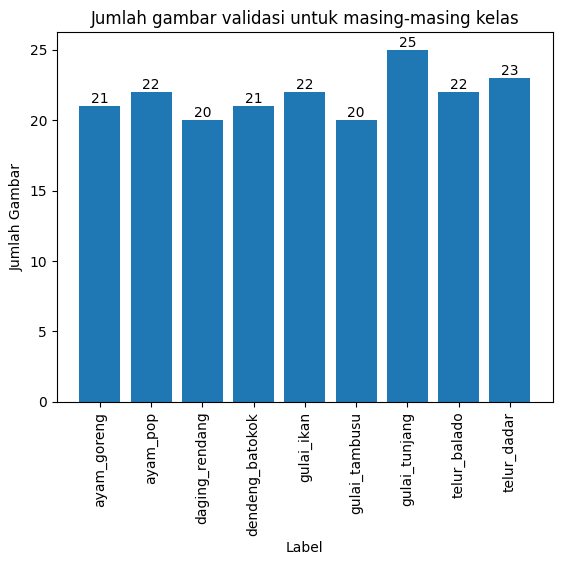

In [ ]:
label_counts = valid_data.classes
unique_labels, counts = np.unique(label_counts, return_counts=True)
label_names = list(train_data.class_indices.keys())

plt.bar(label_names, counts)
plt.title("Jumlah gambar validasi untuk masing-masing kelas")
plt.xlabel('Label')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation='vertical')

for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

In [ ]:
class_labels = train_data.class_indices
code_to_label = {v: k for k, v in class_labels.items()}
print("Class Labels and Their Codes:")
for code, label in code_to_label.items():
    print(f"Code: {code}, Label: {label}")


Class Labels and Their Codes:
Code: 0, Label: ayam_goreng
Code: 1, Label: ayam_pop
Code: 2, Label: daging_rendang
Code: 3, Label: dendeng_batokok
Code: 4, Label: gulai_ikan
Code: 5, Label: gulai_tambusu
Code: 6, Label: gulai_tunjang
Code: 7, Label: telur_balado
Code: 8, Label: telur_dadar


In [ ]:
rescale = tf.keras.Sequential([
   layers.experimental.preprocessing.Resizing(224,224),
   layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
num_classes = 9

# Assuming you have defined train_data_gen and train_data as mentioned above

base_resnet_model = tf.keras.applications.MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
base_resnet_model.trainable = False

resnet_model = tf.keras.models.Sequential([
    base_resnet_model,
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

12683000/12683000 [==============================] - 0s 0us/step


In [ ]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,  # Initial learning rate
    decay_steps=1000,       # Decay learning rate every 'n' steps
    decay_rate=0.9,         # Decay rate
    staircase=True          # Whether to use staircase decay
)

# Compile the model with the custom learning rate
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['accuracy']
)


In [ ]:
resnet_hist = resnet_model.fit(
    train_data,
    epochs=200,
    validation_data=valid_data,
    steps_per_epoch=12
)


Epoch 1/200
12/12 [==============================] - 184s 15s/step - loss: 2.3813 - accuracy: 0.1560 - val_loss: 1.9730 - val_accuracy: 0.2500
Epoch 2/200
12/12 [==============================] - 67s 6s/step - loss: 1.9440 - accuracy: 0.2943 - val_loss: 1.7325 - val_accuracy: 0.4694
Epoch 3/200
12/12 [==============================] - 34s 3s/step - loss: 1.7457 - accuracy: 0.3880 - val_loss: 1.5088 - val_accuracy: 0.6122
Epoch 4/200
12/12 [==============================] - 25s 2s/step - loss: 1.5178 - accuracy: 0.5286 - val_loss: 1.3207 - val_accuracy: 0.7143
Epoch 5/200
12/12 [==============================] - 24s 2s/step - loss: 1.2770 - accuracy: 0.6657 - val_loss: 1.1595 - val_accuracy: 0.7449
Epoch 6/200
12/12 [==============================] - 21s 2s/step - loss: 1.2027 - accuracy: 0.6693 - val_loss: 1.0272 - val_accuracy: 0.7959
Epoch 7/200
12/12 [==============================] - 23s 2s/step - loss: 1.0878 - accuracy: 0.6936 - val_loss: 0.9142 - val_accuracy: 0.7857
Epoch 8/200

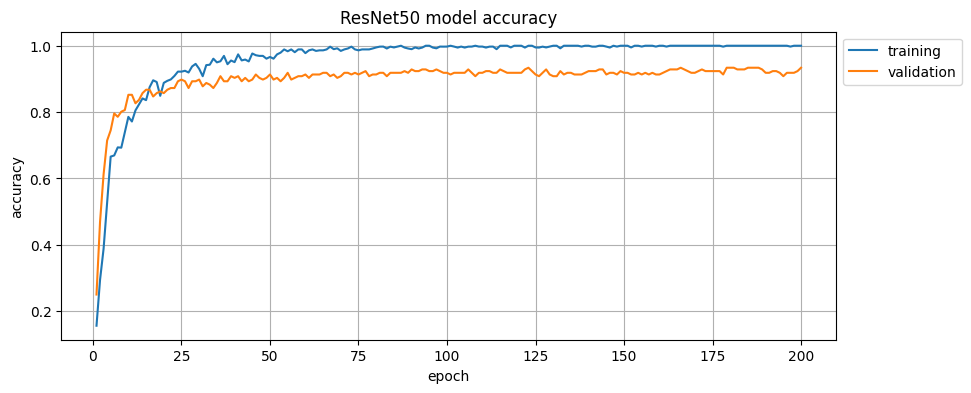

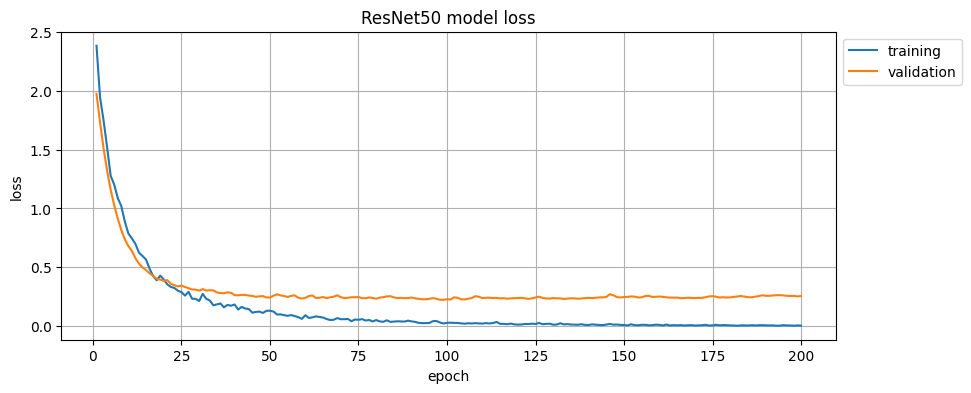

In [ ]:
# Membuat plot akurasi model ResNet50
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(resnet_hist.history['accuracy']) + 1), resnet_hist.history['accuracy'])
plt.plot(range(1, len(resnet_hist.history['val_accuracy']) + 1), resnet_hist.history['val_accuracy'])
plt.title('ResNet50 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)

# Place the legend outside the plot
plt.legend(['training', 'validation'], loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

print()

# Membuat plot loss model ResNet50
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(resnet_hist.history['loss']) + 1), resnet_hist.history['loss'])
plt.plot(range(1, len(resnet_hist.history['val_loss']) + 1), resnet_hist.history['val_loss'])
plt.title('ResNet50 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)

# Place the legend outside the plot
plt.legend(['training', 'validation'], loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [ ]:
# Ambil data akurasi dan loss dari riwayat pelatihan
training_accuracy = resnet_hist.history['accuracy']
validation_accuracy = resnet_hist.history['val_accuracy']
training_loss = resnet_hist.history['loss']
validation_loss = resnet_hist.history['val_loss']

# Hitung nilai rata-rata
average_training_accuracy = np.mean(training_accuracy)
average_validation_accuracy = np.mean(validation_accuracy)
average_training_loss = np.mean(training_loss)
average_validation_loss = np.mean(validation_loss)

print(f"Average Training Accuracy: {average_training_accuracy:.4f}")
print(f"Average Validation Accuracy: {average_validation_accuracy:.4f}")
print(f"Average Training Loss: {average_training_loss:.4f}")
print(f"Average Validation Loss: {average_validation_loss:.4f}")

Average Training Accuracy: 0.9590
Average Validation Accuracy: 0.9001
Average Training Loss: 0.1482
Average Validation Loss: 0.3113


7/7 [==============================] - 8s 987ms/step
Validation Accuracy: 0.1531
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.19      0.19        21
           1       0.09      0.09      0.09        22
           2       0.10      0.10      0.10        20
           3       0.18      0.19      0.19        21
           4       0.17      0.18      0.17        22
           5       0.11      0.10      0.11        20
           6       0.21      0.20      0.20        25
           7       0.24      0.23      0.23        22
           8       0.09      0.09      0.09        23

    accuracy                           0.15       196
   macro avg       0.15      0.15      0.15       196
weighted avg       0.15      0.15      0.15       196

Validation Confusion Matrix:
[[4 5 1 2 1 0 3 2 3]
 [3 2 2 2 2 3 4 0 4]
 [1 4 2 2 3 1 2 3 2]
 [2 2 2 4 4 2 1 3 1]
 [2 1 3 1 4 4 3 2 2]
 [1 3 1 4 0 2 3 3 3]
 [2 1 2 2 4 4 5 1 4]
 [4 

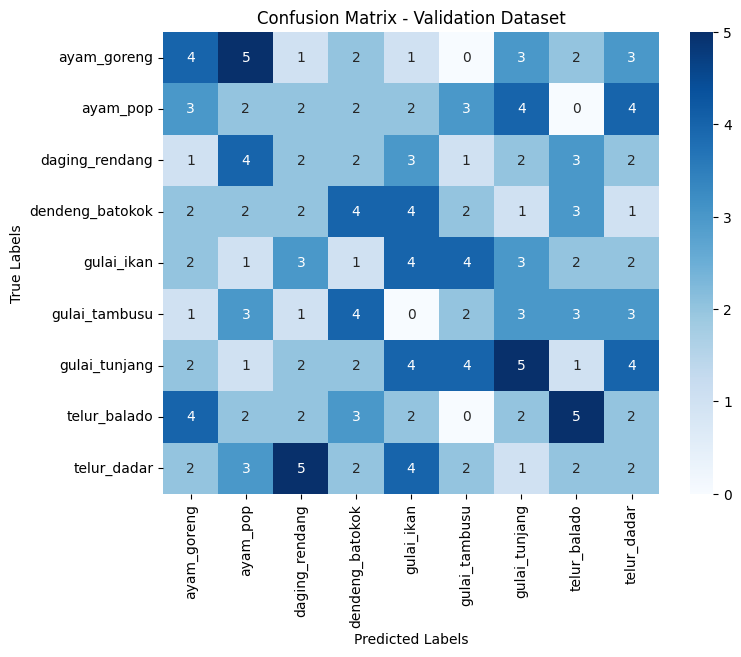

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have valid_y_true and valid_y_pred defined

# Evaluate the model on the validation data
valid_predictions = resnet_model.predict(valid_data)
valid_y_pred = np.argmax(valid_predictions, axis=1)  # Use argmax for multiclass predictions
valid_y_true = valid_data.classes  # Use the validation data labels

# Calculate accuracy for the validation dataset
valid_accuracy = accuracy_score(valid_y_true, valid_y_pred)
print(f"Validation Accuracy: {valid_accuracy:.4f}")

# Generate a classification report for the validation dataset
valid_class_report = classification_report(valid_y_true, valid_y_pred)
print("Validation Classification Report:")
print(valid_class_report)

# Generate a confusion matrix for the validation dataset
valid_confusion_mat = confusion_matrix(valid_y_true, valid_y_pred)
print("Validation Confusion Matrix:")
print(valid_confusion_mat)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(valid_confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix - Validation Dataset')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
